/tmp/ipykernel_8346/3441493339.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load(opt.vgg_dir))
/tmp/ipykernel_8346/3441493339.py:77: Future

----------------- Options ---------------
                batchSize: 1                             
              contentPath: data/content/                 
                     cuda: True                          
              decoder_dir: models/dec_r41.pth            
                 fineSize: 256                           
                    layer: r41                           
                 loadSize: 256                           
               matrixPath: models/r41.pth                
                     outf: Artistic/rotation/            
                stylePath: data/style/                   
                  vgg_dir: models/vgg_r41.pth            
----------------- End -------------------


Processing Styles:   0%|          | 0/21 [00:01<?, ?it/s]


KeyboardInterrupt: 

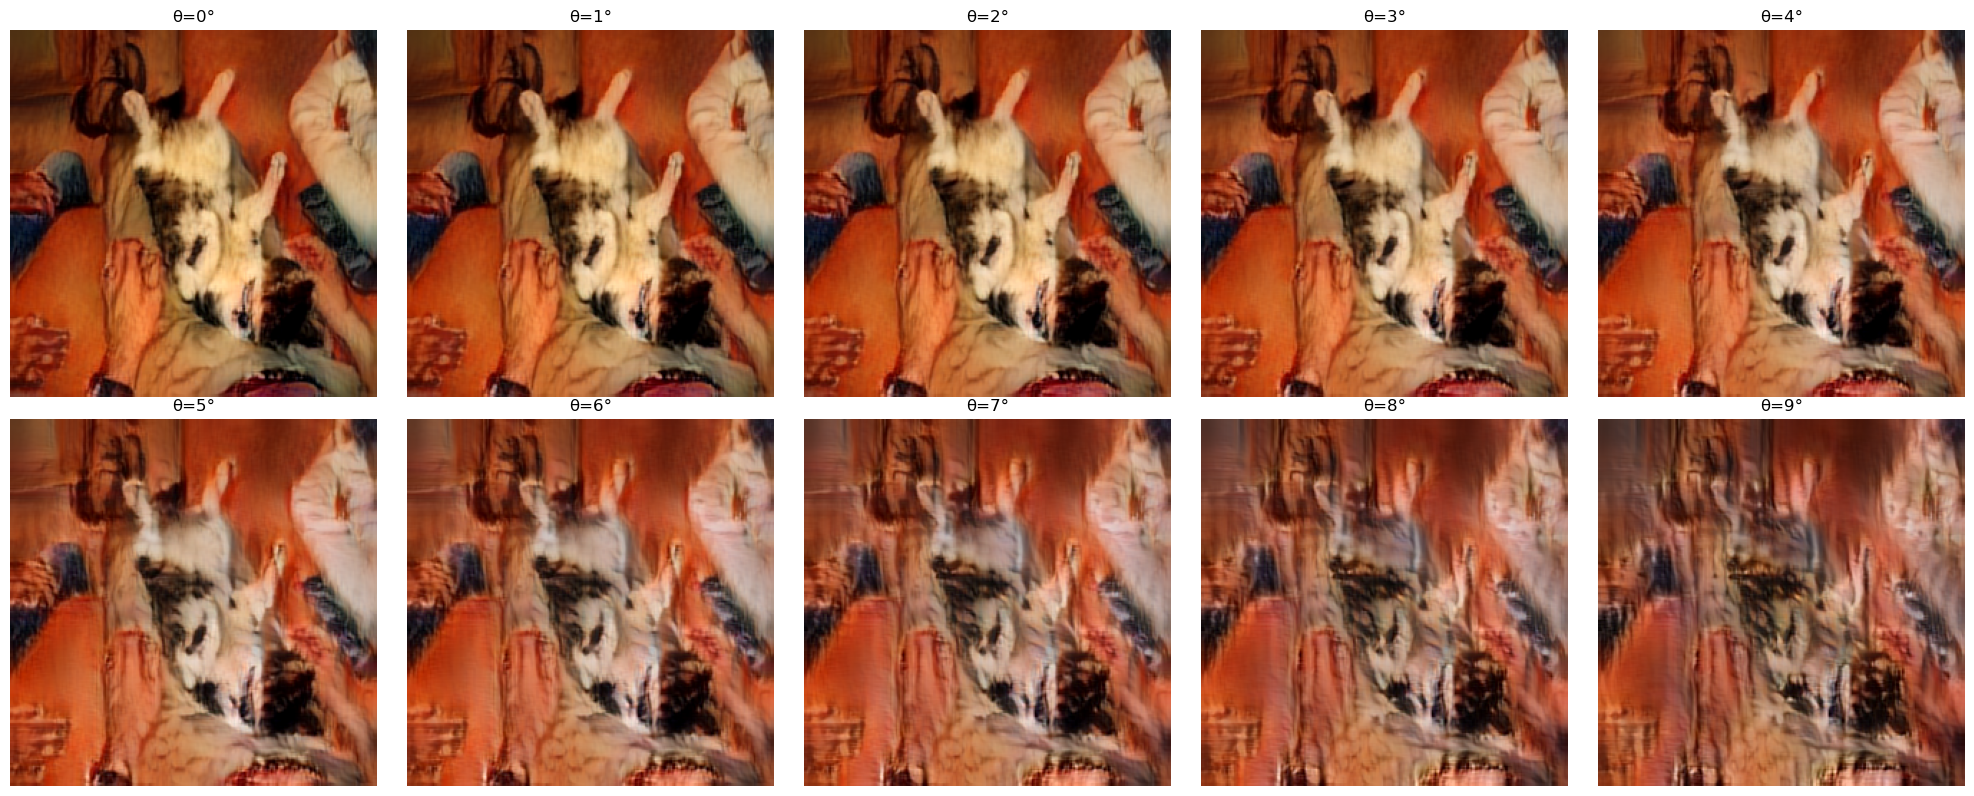

In [2]:
class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.matrixPath = "Matrices/"
        self.vgg_dir = 'models/vgg_r41.pth'
        self.decoder_dir = 'models/dec_r41.pth'
        self.layer = 'r41'
        self.outf = "Artistic/rotation/"
        self.cuda = torch.cuda.is_available()
        self.batchSize = 1
        self.matrixPath = 'models/r41.pth'

if __name__ == "__main__":
    import os
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    import torchvision.transforms as transforms
    from tqdm import tqdm
    from libs.Loader import Dataset
    from libs.Matrix import MulLayer
    from libs.models import encoder3, encoder4, decoder3, decoder4
    from libs.utils import print_options
    import torch.backends.cudnn as cudnn

    def rotate_matrix(matrix, theta_degrees):
        """
        Directly rotate the transformation matrix using rotation in multiple dimensions
        """
        # Convert to numpy for easier manipulation
        matrix_np = matrix.cpu().numpy()
        
        # Get the shape
        original_shape = matrix_np.shape
        
        # Convert angle to radians
        theta = np.radians(theta_degrees)
        
        # Create rotation matrices for each pair of dimensions
        rotated = matrix_np.copy()
        
        # Rotate in multiple planes (taking pairs of dimensions)
        for i in range(original_shape[1] - 1):
            for j in range(i + 1, original_shape[1]):
                # Create rotation matrix for this plane
                rot_matrix = np.eye(original_shape[1])
                rot_matrix[i, i] = np.cos(theta)
                rot_matrix[i, j] = -np.sin(theta)
                rot_matrix[j, i] = np.sin(theta)
                rot_matrix[j, j] = np.cos(theta)
                
                # Apply rotation
                rotated = np.matmul(rotated, rot_matrix)
        
        # Convert back to tensor
        return torch.tensor(rotated, device=matrix.device, dtype=matrix.dtype)

    opt = Options()
    print_options(opt)

    os.makedirs(opt.outf, exist_ok=True)
    cudnn.benchmark = True

    ################# MODEL #################
    if opt.layer == 'r31':
        vgg = encoder3()
        dec = decoder3()
    elif opt.layer == 'r41':
        vgg = encoder4()
        dec = decoder4()
    matrix = MulLayer(opt.layer)
    vgg.load_state_dict(torch.load(opt.vgg_dir))
    dec.load_state_dict(torch.load(opt.decoder_dir))
    matrix.load_state_dict(torch.load(opt.matrixPath))

    ################# GPU #################
    if opt.cuda:
        vgg.cuda()
        dec.cuda()
        matrix.cuda()

    content_files = [f for f in os.listdir(opt.contentPath) if f.endswith(('.jpg', '.jpeg', '.png'))]
    style_files = [f for f in os.listdir(opt.stylePath) if f.endswith(('.jpg', '.jpeg', '.png'))]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((opt.fineSize, opt.fineSize))
    ])

    # Define rotation angles
    thetas = list(range(0, 10, 1))  # 0 to 180 degrees in steps of 30

    # Add progress bar for the style loop
    for style in tqdm(style_files, desc="Processing Styles"):
        style_image = Image.open(opt.stylePath + style).convert('RGB')
        style_tensor = transform(style_image).unsqueeze(0)

        # Add progress bar for the content loop
        for content in tqdm(content_files, desc="Processing Contents", leave=False):
            content_image = Image.open(opt.contentPath + content).convert('RGB')
            content_tensor = transform(content_image).unsqueeze(0)

            contentV = torch.Tensor(1, 3, opt.fineSize, opt.fineSize).copy_(content_tensor)
            styleV = torch.Tensor(1, 3, opt.fineSize, opt.fineSize).copy_(style_tensor)
            
            if opt.cuda:
                contentV = contentV.cuda()
                styleV = styleV.cuda()

            ################# FORWARD PASS WITH ROTATION #################
            images = []  # List to store the images with rotation

            with torch.no_grad():
                sF = vgg(styleV)
                cF = vgg(contentV)

                # Get the original transformation matrix
                if opt.layer == 'r41':
                    feature, transmatrix = matrix(cF[opt.layer], sF[opt.layer], trans=True)
                else:
                    feature, transmatrix = matrix(cF, sF, trans=True)

                compress_content = matrix.compress(cF[opt.layer] if opt.layer == 'r41' else cF)
                b, c, h, w = compress_content.size()
                compress_content = compress_content.view(b, c, -1)

                # Process each rotation angle
                for theta in thetas:
                    # Print shape information for debugging
                    #print(f"Matrix shape before rotation: {transmatrix.shape}")
                    
                    # Rotate the transformation matrix
                    rotated_matrix = rotate_matrix(transmatrix, theta)
                    
                    # Apply the rotated matrix
                    transfeature = torch.bmm(rotated_matrix, compress_content).view(b, matrix.matrixSize, h, w)
                    out = matrix.unzip(transfeature)
                    out = out + torch.mean(cF[opt.layer if opt.layer == 'r41' else cF], dim=(2, 3), keepdim=True)
                    
                    transfer_rotated = dec(out)
                    transfer_rotated = transfer_rotated.clamp(0, 1)
                    
                    img_numpy = transfer_rotated.squeeze().cpu().numpy().transpose(1, 2, 0)
                    images.append(img_numpy)

                    torch.cuda.empty_cache()

            # Plot the results
            num_rows = 2
            num_cols = len(thetas) // 2 + len(thetas) % 2
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))
            
            for idx, ax in enumerate(axes.flatten()):
                if idx < len(images):
                    ax.imshow(images[idx])
                    ax.axis('off')
                    ax.set_title(f'θ={thetas[idx]}°')
                else:
                    ax.axis('off')
                    
            plt.tight_layout()
            plt.savefig(f'{opt.outf}rotation_experiment_{style}_{content}.png')
            plt.close()

            # Also save individual images
            for idx, img in enumerate(images):
                plt.imsave(f'{opt.outf}rotation_{style}_{content}_angle_{thetas[idx]}.png', img)

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from libs.Matrix import MulLayer
from libs.models import encoder3, encoder4, decoder3, decoder4
from libs.utils import print_options
import torch.backends.cudnn as cudnn

class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.vgg_dir = 'models/vgg_r41.pth'
        self.decoder_dir = 'models/dec_r41.pth'
        self.layer = 'r41'
        self.outf = "Artistic/rotation32/"
        self.cuda = torch.cuda.is_available()
        self.batchSize = 1

def create_rotation_matrix(n, i, j, theta):
    """
    Create an n x n rotation matrix that rotates by angle theta in the plane spanned by axes i and j.
    """
    R = np.eye(n)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    R[i, i] = cos_theta
    R[i, j] = sin_theta
    R[j, i] = -sin_theta
    R[j, j] = cos_theta
    return torch.from_numpy(R).float()

if __name__ == "__main__":
    opt = Options()
    print_options(opt)

    os.makedirs(opt.outf, exist_ok=True)
    cudnn.benchmark = True

    ################# MODEL #################
    if opt.layer == 'r31':
        vgg = encoder3()
        dec = decoder3()
    elif opt.layer == 'r41':
        vgg = encoder4()
        dec = decoder4()

    vgg.load_state_dict(torch.load(opt.vgg_dir))
    dec.load_state_dict(torch.load(opt.decoder_dir))

    ################# GPU #################
    if opt.cuda:
        vgg.cuda()
        dec.cuda()

    content_files = [f for f in os.listdir(opt.contentPath) if f.endswith(('.jpg', '.jpeg', '.png'))]
    style_files = [f for f in os.listdir(opt.stylePath) if f.endswith(('.jpg', '.jpeg', '.png'))]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((opt.fineSize, opt.fineSize))
    ])

    # Processing loop
    for style in tqdm(style_files, desc="Processing Styles"):
        style_image = Image.open(os.path.join(opt.stylePath, style)).convert('RGB')
        style_tensor = transform(style_image).unsqueeze(0)

        for content in tqdm(content_files, desc="Processing Contents", leave=False):
            content_image = Image.open(os.path.join(opt.contentPath, content)).convert('RGB')
            content_tensor = transform(content_image).unsqueeze(0)

            contentV = torch.Tensor(1, 3, opt.fineSize, opt.fineSize).copy_(content_tensor)
            styleV = torch.Tensor(1, 3, opt.fineSize, opt.fineSize).copy_(style_tensor)

            if opt.cuda:
                contentV = contentV.cuda()
                styleV = styleV.cuda()

            ################# FORWARD PASS WITH ROTATION MATRIX #################
            with torch.no_grad():
                # Extract features
                sF = vgg(styleV)
                cF = vgg(contentV)

                # Get content features from the specified layer
                content_features = cF[opt.layer if opt.layer == 'r41' else cF]
                b, c, h, w = content_features.size()
                content_features = content_features.view(b, c, -1)  # Shape: [batch_size, channels, height * width]

                # Define the rotation matrix
                n = c  # Number of channels
                theta = np.pi / 4  # Rotation angle in radians
                i, j = 0, 1  # Axes indices to rotate (adjust as needed)
                rotation_matrix = create_rotation_matrix(n, i, j, theta)

                # Move rotation matrix to GPU if necessary
                if opt.cuda:
                    rotation_matrix = rotation_matrix.cuda()

                # Expand rotation matrix to batch size
                rotation_matrix = rotation_matrix.unsqueeze(0).repeat(b, 1, 1)  # Shape: [batch_size, n, n]

                # Apply the rotation to the content features
                rotated_content = torch.bmm(rotation_matrix, content_features)  # Shape: [batch_size, n, height * width]

                # Reshape back to spatial dimensions
                rotated_content = rotated_content.view(b, c, h, w)

                # Pass through the decoder
                out = dec(rotated_content).clamp(0, 1)

                # Convert output to NumPy array for saving
                img_numpy = out.squeeze().cpu().numpy().transpose(1, 2, 0)

                # Save the image
                plt.imsave(f'{opt.outf}{content}_style_{style}_rotated.png', img_numpy)


/tmp/ipykernel_259660/3862664140.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load(opt.vgg_dir))
/tmp/ipykernel_259660/3862664140.py:55: Fu

----------------- Options ---------------
                batchSize: 1                             
              contentPath: data/content/                 
                     cuda: True                          
              decoder_dir: models/dec_r41.pth            
                 fineSize: 256                           
                    layer: r41                           
                 loadSize: 256                           
                     outf: Artistic/rotation32/          
                stylePath: data/style/                   
                  vgg_dir: models/vgg_r41.pth            
----------------- End -------------------


Processing Styles: 100%|██████████| 21/21 [00:19<00:00,  1.05it/s]


In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from libs.Matrix import MulLayer
from libs.models import encoder3, encoder4, decoder3, decoder4
from libs.utils import print_options
import torch.backends.cudnn as cudnn

class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.matrixPath = "Matrices/"
        self.vgg_dir = 'models/vgg_r41.pth'
        self.decoder_dir = 'models/dec_r41.pth'
        self.layer = 'r41'
        self.outf = "Artistic/translation/"
        self.cuda = torch.cuda.is_available()
        self.batchSize = 1
        self.matrixPath = 'models/r41.pth'

def translate_matrix(matrix, x_shift, y_shift):
    """
    Apply translation to the transformation matrix by shifting in the spatial dimensions.
    """
    matrix_np = matrix.cpu().numpy() if matrix.is_cuda else matrix.numpy()
    
    # Shift along height and width (2nd and 3rd dimensions if 3D matrix)
    translated = np.roll(matrix_np, shift=(x_shift, y_shift), axis=(1, 2))  # Apply translation to height and width
    return torch.tensor(translated, device=matrix.device, dtype=matrix.dtype)

if __name__ == "__main__":
    opt = Options()
    print_options(opt)

    os.makedirs(opt.outf, exist_ok=True)
    cudnn.benchmark = True

    ################# MODEL #################
    if opt.layer == 'r31':
        vgg = encoder3()
        dec = decoder3()
    elif opt.layer == 'r41':
        vgg = encoder4()
        dec = decoder4()
    matrix = MulLayer(opt.layer)
    vgg.load_state_dict(torch.load(opt.vgg_dir))
    dec.load_state_dict(torch.load(opt.decoder_dir))
    matrix.load_state_dict(torch.load(opt.matrixPath))

    ################# GPU #################
    if opt.cuda:
        vgg.cuda()
        dec.cuda()
        matrix.cuda()

    content_files = [f for f in os.listdir(opt.contentPath) if f.endswith(('.jpg', '.jpeg', '.png'))]
    style_files = [f for f in os.listdir(opt.stylePath) if f.endswith(('.jpg', '.jpeg', '.png'))]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((opt.fineSize, opt.fineSize))
    ])

    # Define small translations
    translations = [(x, y) for x in range(6) for y in range(6) if (x != 0 or y != 0)]

    # Processing loop
    for style in tqdm(style_files, desc="Processing Styles"):
        style_image = Image.open(os.path.join(opt.stylePath, style)).convert('RGB')
        style_tensor = transform(style_image).unsqueeze(0)

        for content in tqdm(content_files, desc="Processing Contents", leave=False):
            content_image = Image.open(os.path.join(opt.contentPath, content)).convert('RGB')
            content_tensor = transform(content_image).unsqueeze(0)

            contentV = torch.Tensor(1, 3, opt.fineSize, opt.fineSize).copy_(content_tensor)
            styleV = torch.Tensor(1, 3, opt.fineSize, opt.fineSize).copy_(style_tensor)

            if opt.cuda:
                contentV = contentV.cuda()
                styleV = styleV.cuda()

            ################# FORWARD PASS WITH TRANSLATION #################
            with torch.no_grad():
                sF = vgg(styleV)
                cF = vgg(contentV)

                if opt.layer == 'r41':
                    feature, transmatrix = matrix(cF[opt.layer], sF[opt.layer], trans=True)
                else:
                    feature, transmatrix = matrix(cF, sF, trans=True)

                compress_content = matrix.compress(cF[opt.layer] if opt.layer == 'r41' else cF)
                b, c, h, w = compress_content.size()
                compress_content = compress_content.view(b, c, -1)

                # Apply each translation and save images individually
                for (x_shift, y_shift) in translations:
                    translated_matrix = translate_matrix(transmatrix, x_shift, y_shift)
                    
                    transfeature = torch.bmm(translated_matrix, compress_content).view(b, matrix.matrixSize, h, w)
                    out = matrix.unzip(transfeature)
                    out = out + torch.mean(cF[opt.layer if opt.layer == 'r41' else cF], dim=(2, 3), keepdim=True)
                    
                    transfer_translated = dec(out).clamp(0, 1)
                    img_numpy = transfer_translated.squeeze().cpu().numpy().transpose(1, 2, 0)
                    
                    # Save each translated image with a title indicating translation amount
                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.imshow(img_numpy)
                    ax.axis('off')
                    ax.set_title(f'Translation=({x_shift}, {y_shift})')
                    plt.tight_layout()
                    plt.savefig(f'{opt.outf}{content}_style_{style}_translation_{x_shift}_{y_shift}.png')
                    plt.close(fig)




----------------- Options ---------------
                batchSize: 1                             
              contentPath: data/content/                 
                     cuda: True                          
              decoder_dir: models/dec_r41.pth            
                 fineSize: 256                           
                    layer: r41                           
                 loadSize: 256                           
               matrixPath: models/r41.pth                
                     outf: Artistic/translation/         
                stylePath: data/style/                   
                  vgg_dir: models/vgg_r41.pth            
----------------- End -------------------


/tmp/ipykernel_231082/2792762880.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load(opt.vgg_dir))
/tmp/ipykernel_231082/2792762880.py:54: Fu

In [10]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from libs.Matrix import MulLayer
from libs.models import encoder3, encoder4, decoder3, decoder4
from libs.utils import print_options
import torch.backends.cudnn as cudnn

class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.matrixPath = "Matrices/"
        self.vgg_dir = 'models/vgg_r41.pth'
        self.decoder_dir = 'models/dec_r41.pth'
        self.layer = 'r41'
        self.outf = "Artistic/translation1/"
        self.cuda = torch.cuda.is_available()
        self.batchSize = 1
        self.matrixPath = 'models/r41.pth'

def calculate_min_increment(matrix,scale_factor=10):
    """Calculate a larger increment based on the smallest non-zero value in the matrix, scaled by a factor."""
    matrix_np = matrix.cpu().numpy() if matrix.is_cuda else matrix.numpy()
    min_value = np.min(np.abs(matrix_np[np.nonzero(matrix_np)]))
    return min_value * scale_factor  # Scale up the minimum value

def translate_matrix(matrix, x_shift, y_shift, increment):
    """
    Apply fine-grained addition to the entire matrix in spatial dimensions.
    """
    matrix_np = matrix.cpu().numpy() if matrix.is_cuda else matrix.numpy()

    # Extract the height and width from matrix dimensions
    _, height, width = matrix_np.shape
    
    # Create incremental values along x and y axes
    x_increments = np.linspace(0, x_shift + increment, width)
    y_increments = np.linspace(0, y_shift + increment, height)

    # Construct a 2D increment matrix for the spatial dimensions
    increment_matrix = y_increments[:, None] + x_increments  # Shape: (height, width)
    increment_matrix = increment_matrix[None, :, :]  # Expand to shape (1, height, width) for broadcasting

    # Add increment_matrix to the matrix
    translated_matrix = matrix_np + increment_matrix
    
    return torch.tensor(translated_matrix, device=matrix.device, dtype=matrix.dtype)

if __name__ == "__main__":
    opt = Options()
    print_options(opt)

    os.makedirs(opt.outf, exist_ok=True)
    cudnn.benchmark = True

    ################# MODEL #################
    if opt.layer == 'r31':
        vgg = encoder3()
        dec = decoder3()
    elif opt.layer == 'r41':
        vgg = encoder4()
        dec = decoder4()
    matrix = MulLayer(opt.layer)
    vgg.load_state_dict(torch.load(opt.vgg_dir))
    dec.load_state_dict(torch.load(opt.decoder_dir))
    matrix.load_state_dict(torch.load(opt.matrixPath))

    ################# GPU #################
    if opt.cuda:
        vgg.cuda()
        dec.cuda()
        matrix.cuda()

    content_files = [f for f in os.listdir(opt.contentPath) if f.endswith(('.jpg', '.jpeg', '.png'))]
    style_files = [f for f in os.listdir(opt.stylePath) if f.endswith(('.jpg', '.jpeg', '.png'))]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((opt.fineSize, opt.fineSize))
    ])

    # # Calculate the minimum increment for translation
    # min_increment = calculate_min_increment(matrix.state_dict()['compress.weight'])
    # print(f"Minimum increment: {min_increment}")

    min_increment=0.00001

    # Define small granular translations based on min increment
    granular_translations = [(x, y) for x in range(-2, 3) for y in range(-2, 3) if (x != 0 or y != 0)]  # 5x5 grid excluding (0,0)

    #print all the incrementing translations
    print(granular_translations)



    # Processing loop
    for style in tqdm(style_files, desc="Processing Styles"):
        style_image = Image.open(os.path.join(opt.stylePath, style)).convert('RGB')
        style_tensor = transform(style_image).unsqueeze(0)

        for content in tqdm(content_files, desc="Processing Contents", leave=False):
            content_image = Image.open(os.path.join(opt.contentPath, content)).convert('RGB')
            content_tensor = transform(content_image).unsqueeze(0)

            contentV = torch.Tensor(1, 3, opt.fineSize, opt.fineSize).copy_(content_tensor)
            styleV = torch.Tensor(1, 3, opt.fineSize, opt.fineSize).copy_(style_tensor)

            if opt.cuda:
                contentV = contentV.cuda()
                styleV = styleV.cuda()

            ################# FORWARD PASS WITH TRANSLATION #################
            with torch.no_grad():
                sF = vgg(styleV)
                cF = vgg(contentV)

                if opt.layer == 'r41':
                    feature, transmatrix = matrix(cF[opt.layer], sF[opt.layer], trans=True)
                else:
                    feature, transmatrix = matrix(cF, sF, trans=True)

                compress_content = matrix.compress(cF[opt.layer] if opt.layer == 'r41' else cF)
                b, c, h, w = compress_content.size()
                compress_content = compress_content.view(b, c, -1)

                # Set up the figure for the combined subplot (5x5 grid)
                fig, axes = plt.subplots(5, 5, figsize=(12, 12))
                fig.suptitle(f'Content: {content} | Style: {style}', fontsize=16)

                # Apply each granular translation and plot in the grid
                for idx, (x_shift, y_shift) in enumerate(granular_translations):
                    translated_matrix = translate_matrix(transmatrix, x_shift, y_shift, min_increment)
                    
                    transfeature = torch.bmm(translated_matrix, compress_content).view(b, matrix.matrixSize, h, w)
                    out = matrix.unzip(transfeature)
                    out = out + torch.mean(cF[opt.layer if opt.layer == 'r41' else cF], dim=(2, 3), keepdim=True)
                    
                    transfer_translated = dec(out).clamp(0, 1)
                    img_numpy = transfer_translated.squeeze().cpu().numpy().transpose(1, 2, 0)
                    
                    # Plot in the 5x5 grid
                    ax = axes[idx // 5, idx % 5]
                    ax.imshow(img_numpy)
                    ax.axis('off')
                    ax.set_title(f'({x_shift * min_increment:.4f}, {y_shift * min_increment:.4f})')

                # Save the combined grid plot
                plt.tight_layout()
                plt.subplots_adjust(top=0.95)
                plt.savefig(f'{opt.outf}{content}_style_{style}_translations_combined.png')
                plt.close(fig)


/tmp/ipykernel_8846/4276392007.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load(opt.vgg_dir))
/tmp/ipykernel_8846/4276392007.py:72: Future

----------------- Options ---------------
                batchSize: 1                             
              contentPath: data/content/                 
                     cuda: True                          
              decoder_dir: models/dec_r41.pth            
                 fineSize: 256                           
                    layer: r41                           
                 loadSize: 256                           
               matrixPath: models/r41.pth                
                     outf: Artistic/translation1/        
                stylePath: data/style/                   
                  vgg_dir: models/vgg_r41.pth            
----------------- End -------------------
[(-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2), (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2), (0, -2), (0, -1), (0, 1), (0, 2), (1, -2), (1, -1), (1, 0), (1, 1), (1, 2), (2, -2), (2, -1), (2, 0), (2, 1), (2, 2)]


Processing Styles: 100%|██████████| 21/21 [10:15<00:00, 29.33s/it]


----------------- Options ---------------
                batchSize: 1                             
              contentPath: data/content/                 
                     cuda: True                          
              decoder_dir: models/dec_r41.pth            
                 fineSize: 256                           
                    layer: r41                           
                 loadSize: 256                           
               matrixPath: models/r41.pth                
                     outf: Artistic/rotation_translation_combined/
                stylePath: data/style/                   
                  vgg_dir: models/vgg_r41.pth            
----------------- End -------------------


/tmp/ipykernel_26118/590817456.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load(opt.vgg_dir, map_location=torch.device('cuda' if opt.cuda

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [1, 32] but got: [1, 512].

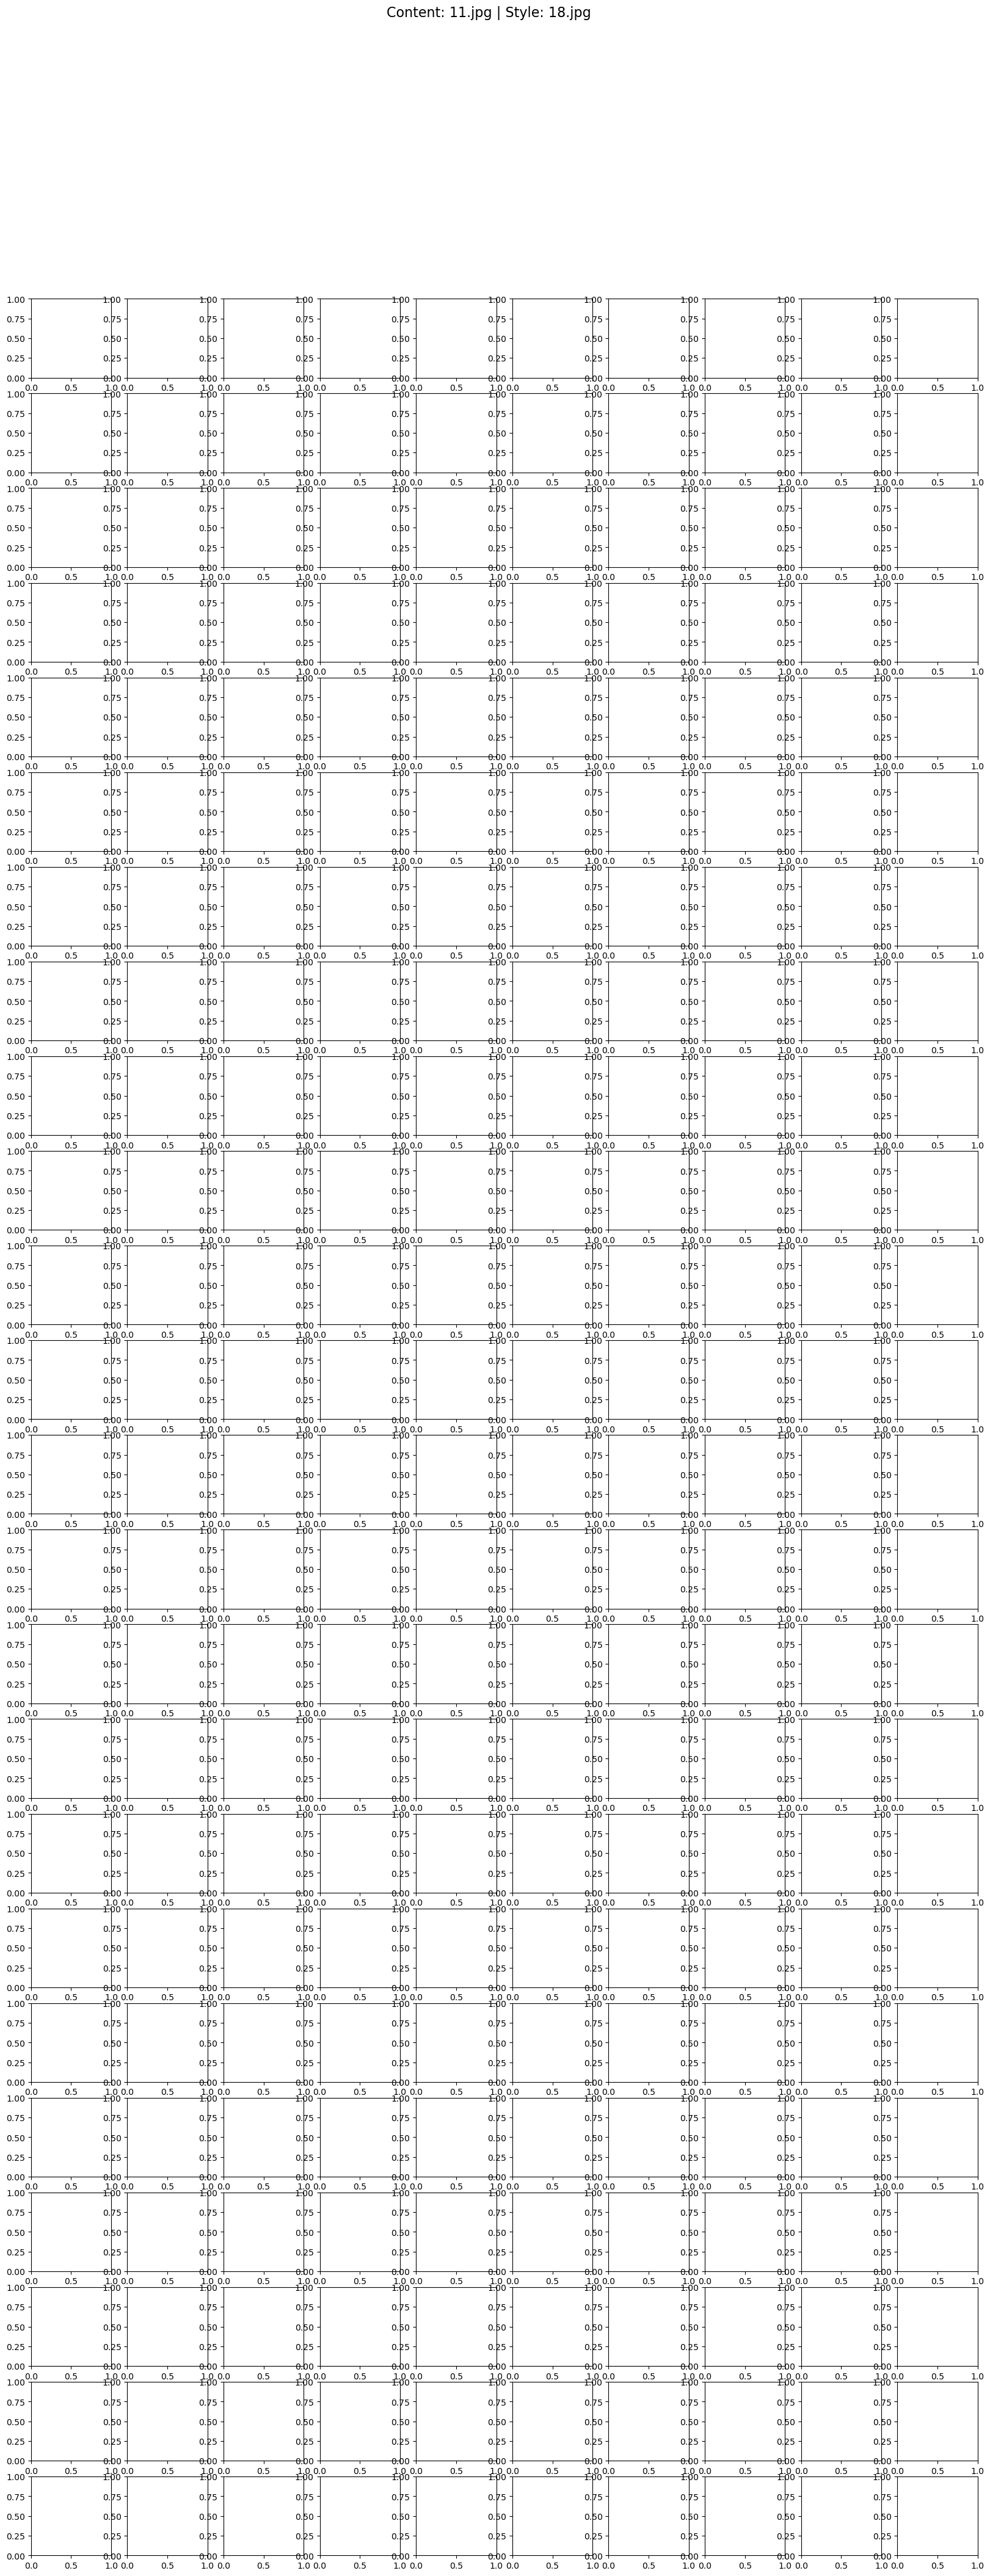

In [16]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
from libs.Matrix import MulLayer
from libs.models import encoder3, encoder4, decoder3, decoder4
from libs.utils import print_options
import torch.backends.cudnn as cudnn

class Options:
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.matrixPath = "models/r41.pth"
        self.vgg_dir = 'models/vgg_r41.pth'
        self.decoder_dir = 'models/dec_r41.pth'
        self.layer = 'r41'
        self.outf = "Artistic/rotation_translation_combined/"
        self.cuda = torch.cuda.is_available()
        self.batchSize = 1

def transform_matrix(matrix, x_shift, y_shift, angle_degrees):
    batch_size, out_channels, in_channels = matrix.size()
    
    # Create normalized transformations for affine grid
    x_shift_norm = 2 * x_shift / in_channels
    y_shift_norm = 2 * y_shift / out_channels
    angle_rad = np.radians(angle_degrees)

    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)

    # Define the affine transformation matrix
    transform_matrix = torch.tensor([
        [cos_theta, -sin_theta, x_shift_norm],
        [sin_theta, cos_theta, y_shift_norm]
    ], device=matrix.device).float()

    # Expand for batch processing
    transform_matrix = transform_matrix.unsqueeze(0).repeat(batch_size, 1, 1)

    # Create affine grid and apply transformations
    grid = F.affine_grid(transform_matrix, size=(batch_size, 1, out_channels, in_channels), align_corners=False)
    matrix_spatial = matrix.view(batch_size, 1, out_channels, in_channels)
    transformed = F.grid_sample(matrix_spatial, grid, align_corners=False)

    # Reshape back to original form
    transformed = transformed.view(batch_size, out_channels, in_channels)
    
    return transformed

def process_style_transfer(vgg, dec, matrix, content_tensor, style_tensor, opt, x_shift=0, y_shift=0, angle=0):
    with torch.no_grad():
        sF = vgg(style_tensor)
        cF = vgg(content_tensor)
        
        if opt.layer == 'r41':
            base_feature, base_matrix = matrix(cF[opt.layer], sF[opt.layer], trans=True)
            
            transformed_matrix = transform_matrix(
                base_matrix,
                x_shift,
                y_shift,
                angle
            )
            
            # Reshape cF for batch multiplication
            b, c, h, w = cF[opt.layer].size()
            cF_reshaped = cF[opt.layer].view(b, c, -1)

            # Perform batch matrix multiplication
            feature = torch.bmm(transformed_matrix, cF_reshaped)
            feature = feature.view(b, c, h, w)
            
        else:
            base_feature, base_matrix = matrix(cF, sF, trans=True)
            
            transformed_matrix = transform_matrix(
                base_matrix,
                x_shift,
                y_shift,
                angle
            )
            
            b, c, h, w = cF.size()
            cF_reshaped = cF.view(b, c, -1)

            feature = torch.bmm(transformed_matrix, cF_reshaped)
            feature = feature.view(b, c, h, w)
        
        return transformed_matrix, cF, feature

def main():
    opt = Options()
    print_options(opt)
    
    os.makedirs(opt.outf, exist_ok=True)
    cudnn.benchmark = True
    
    vgg = encoder4() if opt.layer == 'r41' else encoder3()
    dec = decoder4() if opt.layer == 'r41' else decoder3()
    matrix = MulLayer(opt.layer)
    
    vgg.load_state_dict(torch.load(opt.vgg_dir, map_location=torch.device('cuda' if opt.cuda else 'cpu')))
    dec.load_state_dict(torch.load(opt.decoder_dir, map_location=torch.device('cuda' if opt.cuda else 'cpu')))
    matrix.load_state_dict(torch.load(opt.matrixPath, map_location=torch.device('cuda' if opt.cuda else 'cpu')))
    
    if opt.cuda:
        vgg.cuda()
        dec.cuda()
        matrix.cuda()
    
    transform = transforms.Compose([
        transforms.Resize((opt.fineSize, opt.fineSize)),
        transforms.ToTensor()
    ])
    
    content_files = [f for f in os.listdir(opt.contentPath) if f.endswith(('.jpg', '.jpeg', '.png'))]
    style_files = [f for f in os.listdir(opt.stylePath) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    pixel_shift = 32
    translations = [(x, y) for x in range(-2, 3) for y in range(-2, 3) if (x != 0 or y != 0)]
    rotation_angles = list(range(0, 360, 36))
    
    for style_file in tqdm(style_files, desc="Processing Styles"):
        style_image = Image.open(os.path.join(opt.stylePath, style_file)).convert('RGB')
        style_tensor = transform(style_image).unsqueeze(0)
        if opt.cuda:
            style_tensor = style_tensor.cuda()
        
        for content_file in tqdm(content_files, desc="Processing Contents", leave=False):
            content_image = Image.open(os.path.join(opt.contentPath, content_file)).convert('RGB')
            content_tensor = transform(content_image).unsqueeze(0)
            if opt.cuda:
                content_tensor = content_tensor.cuda()
            
            num_translations = len(translations)
            num_rotations = len(rotation_angles)
            fig, axes = plt.subplots(num_translations, num_rotations, figsize=(2*num_rotations, 2*num_translations))
            fig.suptitle(f'Content: {content_file} | Style: {style_file}', fontsize=16)
            
            with torch.no_grad():
                for t_idx, (x_shift, y_shift) in enumerate(translations):
                    for r_idx, theta in enumerate(rotation_angles):
                        _, cF, feature = process_style_transfer(
                            vgg, dec, matrix, content_tensor, style_tensor, opt,
                            x_shift * pixel_shift, y_shift * pixel_shift, theta
                        )
                        
                        if opt.layer == 'r41':
                            out = feature + torch.mean(cF[opt.layer], dim=(2, 3), keepdim=True)
                        else:
                            out = feature + torch.mean(cF, dim=(2, 3), keepdim=True)
                        
                        transfer = dec(out).clamp(0, 1)
                        img_numpy = transfer.detach().squeeze().cpu().numpy().transpose(1, 2, 0)
                        
                        axes[t_idx, r_idx].imshow(img_numpy)
                        axes[t_idx, r_idx].axis('off')
                        axes[t_idx, r_idx].set_title(f'T({x_shift*pixel_shift},{y_shift*pixel_shift})\nR({theta}°)', fontsize=8)
            
            plt.tight_layout()
            plt.savefig(os.path.join(opt.outf, f'{os.path.splitext(content_file)[0]}_style_{os.path.splitext(style_file)[0]}_combined.png'))
            plt.close(fig)
            
            torch.cuda.empty_cache()

if __name__ == "__main__":
    main()
